In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns                         #for visualiing columns of the dataframe
tf.config.run_functions_eagerly(False)
from tensorflow import keras
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from sklearn.model_selection import train_test_split    #to split train and test data
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
import os
from tensorflow.keras.models import Model, load_model
import warnings
warnings.filterwarnings('ignore')

In [34]:
maindir = "/kaggle/input/utkface-new/UTKFace"
files = os.listdir(maindir)
size = len(files)
print('total files:', size)
print(files[:3])

total files: 23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


In [35]:
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
np.random.shuffle(files)

In [37]:
files[0]

'85_0_0_20170111210408610.jpg.chip.jpg'

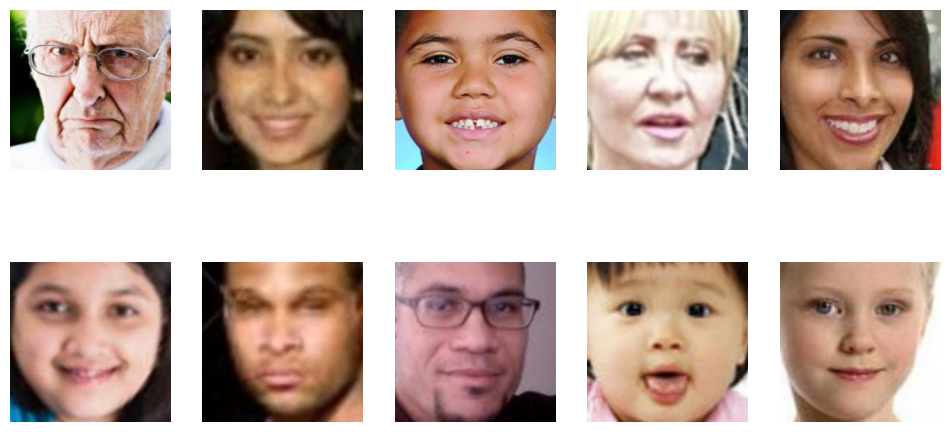

In [38]:
fig, ax = plt.subplots(2,5, figsize=(12, 6), sharex=True, sharey=True)
for image_idx in range(10):
    ax[image_idx//5, image_idx%5].imshow(Image.open(os.path.join(maindir,files[image_idx])))
    ax[image_idx//5, image_idx%5].axis('off')
plt.show()

# **Pre-processing**

* The file names are like for example, 1_0_0239389.JPG means the age is 1 and gender is male which is 0 and race is black which is not required in this task.
* We split the file name on the _ and put each of them in separate lists.
* We are even shuffling the images for more randomness.

In [39]:
np.random.seed(10)
np.random.shuffle(files)

age_labels = []             #list with the ages of the images separated from the filename
gender_labels = []          #list with the gender of the images separated from the filename
image_path = []             #path to the image

for filename in files:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [40]:
image_path

['30_0_0_20170117143352248.jpg.chip.jpg',
 '61_0_2_20170112205453108.jpg.chip.jpg',
 '26_0_0_20170117003342340.jpg.chip.jpg',
 '24_1_1_20170112234612457.jpg.chip.jpg',
 '55_0_0_20170117184812800.jpg.chip.jpg',
 '16_1_0_20170109212513215.jpg.chip.jpg',
 '27_1_1_20170112213510151.jpg.chip.jpg',
 '24_1_2_20170116171158821.jpg.chip.jpg',
 '26_0_4_20170117152500051.jpg.chip.jpg',
 '52_0_0_20170120222910474.jpg.chip.jpg',
 '31_0_1_20170116165733463.jpg.chip.jpg',
 '49_1_0_20170104235723082.jpg.chip.jpg',
 '84_1_0_20170120230440130.jpg.chip.jpg',
 '27_1_2_20170116173459838.jpg.chip.jpg',
 '26_0_0_20170117195926293.jpg.chip.jpg',
 '1_0_2_20161219194721851.jpg.chip.jpg',
 '40_0_1_20170116203957000.jpg.chip.jpg',
 '42_0_0_20170117154803642.jpg.chip.jpg',
 '50_0_0_20170116224809437.jpg.chip.jpg',
 '5_0_3_20170119212110570.jpg.chip.jpg',
 '30_0_0_20170117143502368.jpg.chip.jpg',
 '4_0_4_20161221192742413.jpg.chip.jpg',
 '45_0_1_20170113183252060.jpg.chip.jpg',
 '13_0_0_20170110225059227.jpg.chip.j

* Resizing and normalizing the pixel range within 0 and 1 
* Visulalizing the pre-processed images

In [41]:

def preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.array(image) / 255.0              # Normalize pixel values to the range [0, 1]
    return image

* We are creating 2x5 grid for subplot and then preprocess the image on the corresponding subplot
* We then calculate the row index and column index by floor dividing the index variable 5 and modulus 5 respectively.

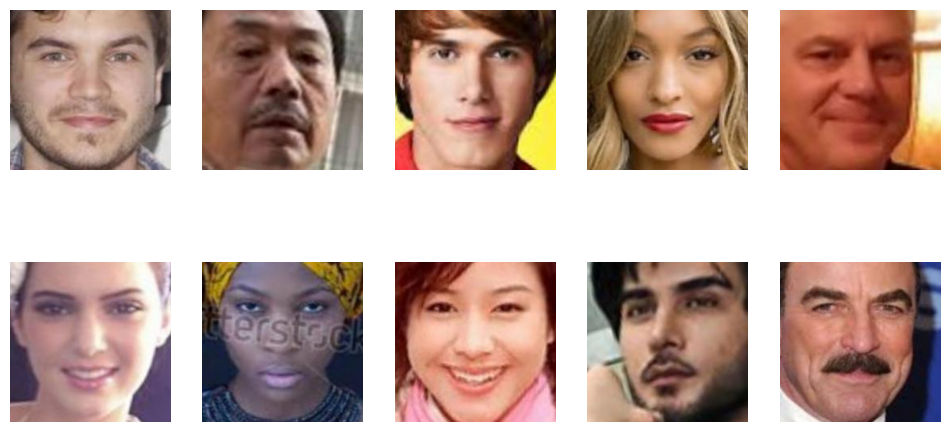

In [42]:
# Displaying the preprocessed images
fig, ax = plt.subplots(2, 5, figsize=(12, 6), sharex=True, sharey=True)   # we create a 2x5 grid for images
for image_idx in range(10):
    image = preprocess_image(os.path.join(maindir, files[image_idx]))
    ax[image_idx//5, image_idx%5].imshow(image)                           # //5 will calculate row index
    ax[image_idx//5, image_idx%5].axis('off')                             # %5 will calculate column index
plt.show()

# Converting From Unstructured to Structured data

In [43]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [14]:
#Displaying the first 5 records of the dataframe
df.head()

,image,age,gender
0,30_0_0_20170117143352248.jpg.chip.jpg,30,0
1,61_0_2_20170112205453108.jpg.chip.jpg,61,0
2,26_0_0_20170117003342340.jpg.chip.jpg,26,0
3,24_1_1_20170112234612457.jpg.chip.jpg,24,1
4,55_0_0_20170117184812800.jpg.chip.jpg,55,0


In [44]:
#Creating a dictionary for gender 
gender_dict = {0:"Male",1:"Female"}

In [45]:
#Specifying the datatype for age and gender column
df = df.astype({'age':'float32', 'gender': 'int32'})

In [46]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


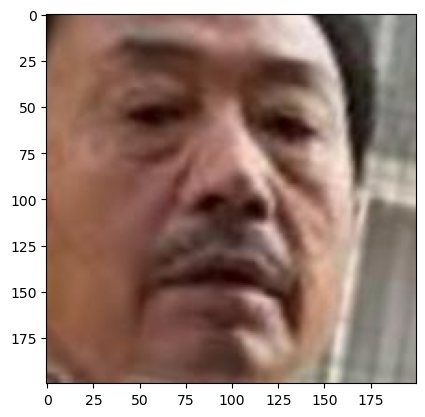

In [47]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/"+df.image[1])
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

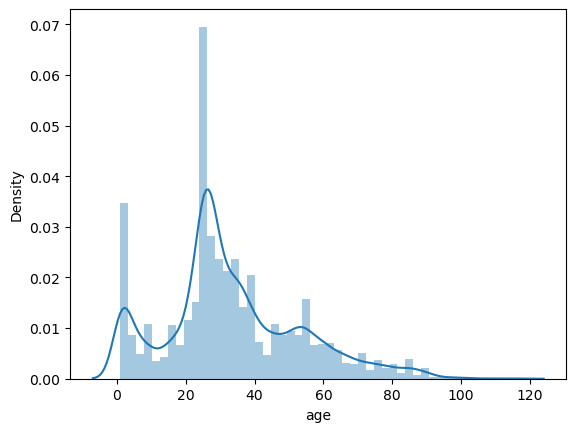

In [48]:
sns.distplot(df.age)        # we are visualizing age column of the database using seaborn library

# Plotting the Images

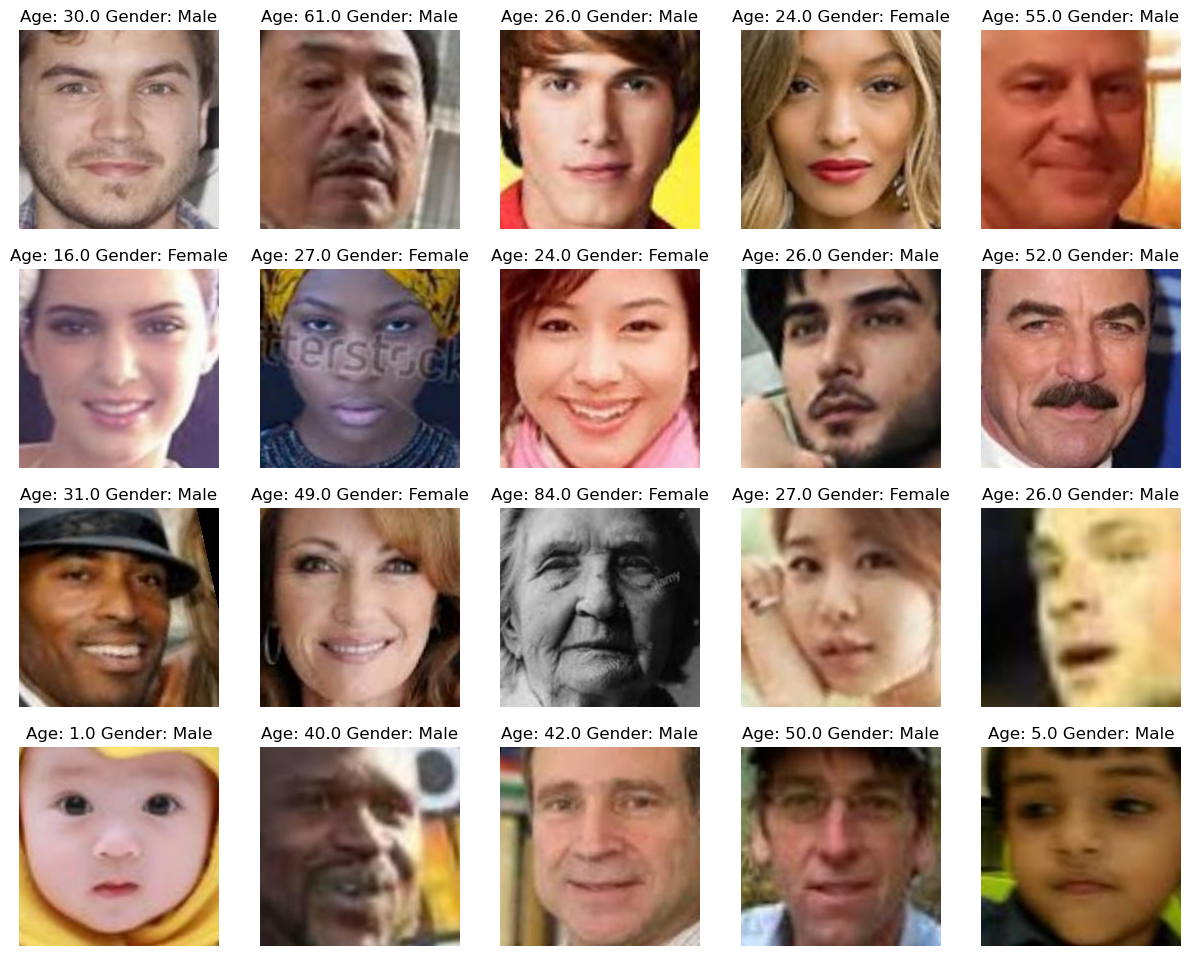

In [49]:
files = df.iloc[0:20]          #create new dataframe files of the first 20 rows of the original dataframe

plt.figure(figsize=(15,15))     #display images of 15x15 size
for index, file, age, gender in files.itertuples():      #loop iterates over each row in the files dataframe
    plt.subplot(5,5, index+1)                            #creating subplot within each figure
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file)
    img = np.array(img)                                  #converts loaded image into numpy array
    plt.imshow(img)                                      
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')                                      #removes the axis ticks and labels

In [50]:
#we split the dataset into train and test, in which train size is 70% and test size is 30%.
train, test = train_test_split(df, test_size=0.30, random_state=42)

In [51]:
train.head()

,image,age,gender
6045,26_0_3_20170117154452224.jpg.chip.jpg,26.0,0
7503,26_1_1_20170112211527323.jpg.chip.jpg,26.0,1
12843,47_0_0_20170107213329593.jpg.chip.jpg,47.0,0
14525,26_1_1_20170117091458401.jpg.chip.jpg,26.0,1
9728,59_0_0_20170109010613005.jpg.chip.jpg,59.0,0


In [52]:
test.head()

,image,age,gender
17525,28_1_2_20170116192755650.jpg.chip.jpg,28.0,1
1147,8_1_2_20170109201847910.jpg.chip.jpg,8.0,1
1190,25_1_2_20170116165500425.jpg.chip.jpg,25.0,1
9731,9_0_0_20170110224611885.jpg.chip.jpg,9.0,0
7387,19_0_1_20170113132630232.jpg.chip.jpg,19.0,0


# Extracting the features 

In [53]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:                       #iterate through image column
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)                    #resize the image
    img = np.array(img)                                             #convert img into 2d numpy array
    x_train.append(img)                                             #add the 2d numpy array to the list

x_train = np.array(x_train)                                #convert list into 3d numpy array            

x_train = x_train.reshape(len(x_train), 128,128,1)   #we are reshaping to prepare it to use in CNN model

In [54]:
x_train.shape

(16595, 128, 128, 1)

# Normalizing the train data

In [55]:
#normalizes the pixel values wihtin range [0,1]
x_train = x_train/255    

In [56]:
# we create numpy array for gender and age from gender and age column in the dataframe
y_gender = np.array(train.gender)   
y_age = np.array(train.age)

In [57]:
# the height and width are taken as 128 pixels and the channel is 1 because it is a grey scale image 
# ie., there is only one piece of information(brightness) associated with each pixel 
input_size = (128,128,1)

# Creating Model

We use **convolutional neural networks** but with **skip connections/residual connections**. We do this to improve the training and performance of deep neural networks.

In [58]:
# the input size which is the input shape of the image and is passed to the input layer 
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
                          #we are adding a 2d convolutional layer with 64 filters of size(3,3)
                          #ReLU activation function is applied to the outputs
                          #weights are initialized to glorot uniform initializer
X = BatchNormalization(axis = 3)(X)         #we add a batch normalization layer to normalize outputs
                                            #of previous convolutional layer
X = MaxPooling2D((3, 3))(X)                 #max pooling ie., we are reducing the dimensions of the 
                                            #image and max meaning the sharpest features are extracted
    
X = Conv2D(128, (3, 3), activation='relu')(X)   #128 filters
X = MaxPooling2D((2, 2), strides=(2, 2))(X)     

X = Conv2D(256, (3, 3), activation='relu')(X)   #256 filters
X = MaxPooling2D((2, 2))(X)                     

X = Flatten()(X)                       #we convert 3d feature maps to 1d vector to send it to dense layer

dense_1 = Dense(256, activation='relu' )(X)      #fully connected dense layer with 256 units
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)               #dropout layer with dropout rate 0.4
dropout_2 = Dropout(0.4)(dense_3)               #helps prevent overfitting
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)   #we add output layer 
                    #for gender detection having a single neuron with sigmoid func(probability[0-1])
                                                                            
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)  #age prediction using ReLU 
                                                                      #for non-negative values

model = Model(inputs=[inputs], outputs=[output_1,output_2]) #creating a model

In [59]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 126, 126, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 126, 126, 64  256        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

# Training the model

In [61]:
#we train the model with batch size 10 and 20 epochs and validation split of 10% of the training data
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
1494/1494 [==============================] - 494s 330ms/step - loss: 12.9159 - gender_output_loss: 0.5253 - age_output_loss: 12.3906 - gender_output_accuracy: 0.7531 - age_output_accuracy: 0.0439 - val_loss: 11.0789 - val_gender_output_loss: 0.3971 - val_age_output_loss: 10.6818 - val_gender_output_accuracy: 0.8235 - val_age_output_accuracy: 0.0530
Epoch 2/20
1494/1494 [==============================] - 484s 324ms/step - loss: 9.6875 - gender_output_loss: 0.3568 - age_output_loss: 9.3307 - gender_output_accuracy: 0.8417 - age_output_accuracy: 0.0220 - val_loss: 9.5283 - val_gender_output_loss: 0.3361 - val_age_output_loss: 9.1923 - val_gender_output_accuracy: 0.8488 - val_age_output_accuracy: 0.0048
Epoch 3/20
1494/1494 [==============================] - 492s 329ms/step - loss: 8.8196 - gender_output_loss: 0.3201 - age_output_loss: 8.4995 - gender_output_accuracy: 0.8599 - age_output_accuracy: 0.0157 - val_loss: 8.9523 - val_gender_output_loss: 0.3434 - val_age_output_loss: 

# Visualizing loss

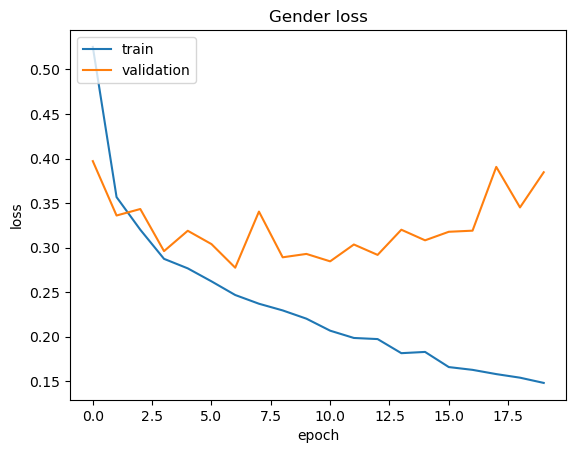

In [63]:
#we plot training and validation loss for gender classification over the epochs
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

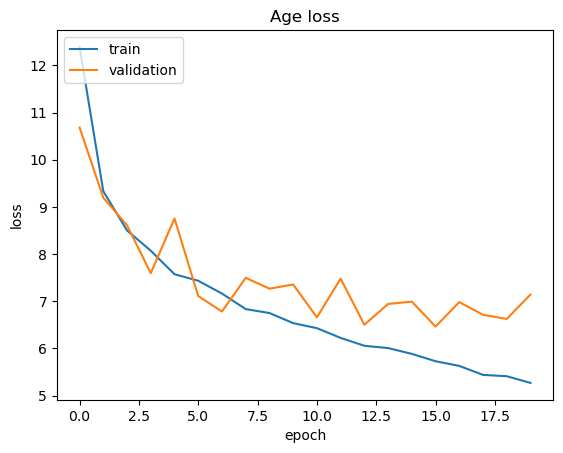

In [64]:
#we plot training and validation loss for age prediction over the epochs
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting the test Image

Original: Gender =  Female  Age =  28.0
1/1 [==============================] - 0s 213ms/step
Prediction: Gender =  Female  Age =  30


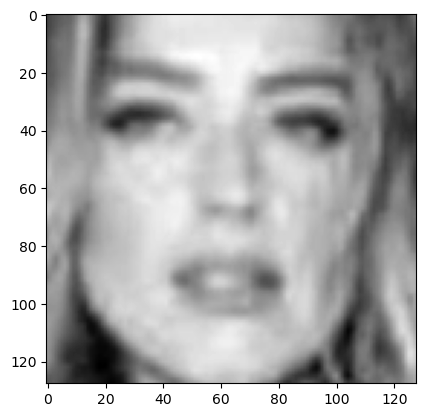

In [65]:
index=25                   #let us take an image of index 100 in x_train
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  5.0
1/1 [==============================] - 0s 33ms/step
Prediction: Gender =  Female  Age =  8


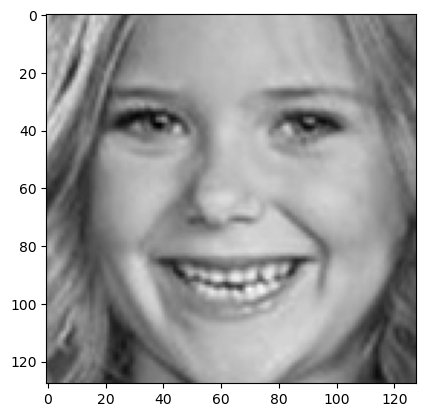

In [67]:
index=55                   #let us take an image of index 100 in x_train
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  29.0
1/1 [==============================] - 0s 39ms/step
Prediction: Gender =  Female  Age =  30


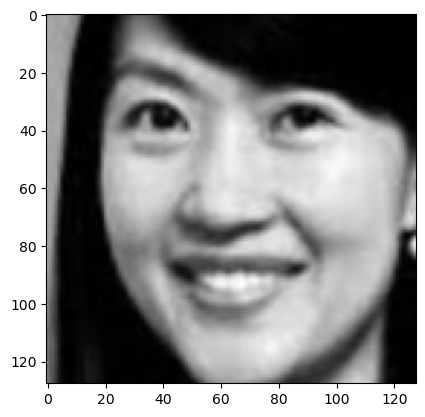

In [68]:
index=71                   #let us take an image of index 100 in x_train
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Male  Age =  35.0
1/1 [==============================] - 0s 34ms/step
Prediction: Gender =  Male  Age =  32


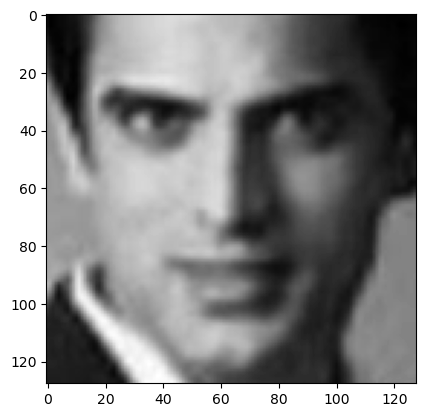

In [77]:
index=768                   #let us take an image of index 100 in x_train
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')